Notebook to replicate the results from _Section 5: Understanding scaling laws for denoising theoretically_ from the paper **Scaling Laws For Deep Learning Based Image Reconstruction**

In [1]:
# PCA
from sklearn.decomposition import PCA

# other
import torch
import numpy as np
from scipy.linalg import orth
import matplotlib.pyplot as plt

# Device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
dtype = torch.cuda.FloatTensor

## Data model

In [2]:
class dataGen():
    
    def __init__(self,n,d):
        # n: ambient dimension
        # d: signal dimension
        
        # subspace model
        self.U = torch.from_numpy( orth(np.random.normal(loc=0, scale=1, size=[n,d])) ) 
        
    def create_train_data(self, n, d, N, sigma_z=0):
        # n: ambient dimension
        # d: signal dimension
        # N: number of training samples
        # sigma_z: noise standard deviation
        
        # train data
        self.C = torch.from_numpy( np.random.normal(loc=0, scale=1.0, size=[d,N]) )
        self.z = torch.from_numpy( np.random.normal(loc=0, scale=sigma_z, size=[n,N]) )
        self.trX = self.U @ self.C
        
        self.trY = self.trX + self.z

## Estimators

### The estimator learned with gradient descent in the limit of infinite many iterations

In [3]:
class gradient_descent_converged():
    '''
    The estimator learned with gradient descent if we let the number of iterations go to infinity.
    '''    
    def test_risk(self, U, sigma_z):
        '''
        Compute the risk for a given estimator W subspace U and noise statistics sigma_z.
        '''
        n = U.shape[0]
        d = U.shape[1]
        risk = np.linalg.norm( (self.W - np.eye(n)) @ U ,'fro')**2 + sigma_z**2 * np.linalg.norm(self.W,'fro')**2
        return risk/d
    
    def compute_GDconv_estimate(self, trX, trY, U, sigma_z):
        '''
        Compute the estimator from training data and return its risk.
        '''
        self.W = trX @ np.linalg.pinv(trY)
        
        teL = self.test_risk(U, sigma_z)
        return teL.item()

### The estimator learned with gradient descent

In [4]:
class GD_model():
    '''
    Learn an estimator bwith gradient descent form the data X,Y
    '''
    def __init__(self, n):
        self.n = n
        self.W = torch.zeros([n,n]).type(dtype)
    
    def test_risk(self, U, sigma_z):
        '''
        Compute the risk for a given estimator W subspace U and noise statistics sigma_z.
        '''
        n = U.shape[0]
        d = U.shape[1]
        risk = torch.linalg.norm( (self.W - torch.eye(n).type(dtype)) @ U ,'fro')**2 + sigma_z**2 * torch.linalg.norm(self.W,'fro')**2
        return risk/d
    
    def train(self, trX, trY, U, sigma_z, num_iters=1000, lr = 1e-2):
        trainL_emp = []
        testL = []

        N = trX.shape[-1]
        d = U.shape[1]
        early_stopping_counter = 0
        early_stopping_loss = 10000
        for i in range(num_iters):
            if i % 100 == 0:
                print('Iteration : {}/{}'.format(i,num_iters))
            ### train
            # compute the gradient
            dW = self.W @ trY @ trY.T - trX @ trY.T
            
            # update the weights
            self.W -= lr*dW
            
            # train loss
            Xhat = self.W @ trY
            trl =  ( (Xhat-trX)**2 ).sum()/(N*d)
            trainL_emp.append(trl.item())
            
            ### test
            tel = self.test_risk(U, sigma_z)
            testL.append(tel.item())
            
            # Stop if train loss is not improving anymore
            if i>100 and np.abs(trainL_emp[-1]-trainL_emp[-2]) < 1e-20:
                print('Stopped at iteration {} due to convergence'.format(i))
                break
            
            
            # Early stopp 100 iterations after the test loss reached its minimum
            if testL[-1] < early_stopping_loss:
                early_stopping_loss = testL[-1]
            else:
                early_stopping_counter += 1
            if early_stopping_counter == 100:
                print('Stopped at iteration {} due to early stopping'.format(i))
                break
            
        return testL, trainL_emp

### Subspace estimation with PCA

In [5]:
class PCA_based_reconstruction():
    '''
    Estimator based on estimating the subspace with PCA on the data in Y.
    '''
    def __init__(self):
        self.pca = PCA()

    def test_risk(self, U, sigma_z):
        '''
        Compute the risk for a given estimator W subspace U and noise statistics sigma_z.
        '''
        n = U.shape[0]
        d = U.shape[1]
        risk = np.linalg.norm( (self.W - np.eye(n)) @ U ,'fro')**2 + sigma_z**2 * np.linalg.norm(self.W,'fro')**2
        return risk/d
        
    def compute_subspace_estimate(self, trY, U, sigma_z):
        '''
        Compute the estimator from training data and return its risk.
        '''
        d = U.shape[1]
        U_,S,V = np.linalg.svd(trY @ trY.T)
        self.Uhat = U_[:,:d]        
        self.W = 1/(1+sigma_z**2)* self.Uhat @ self.Uhat.T 
        
        teL = self.test_risk(U, sigma_z)
        return teL.item()

### Risk minimizing optimal solution

In [6]:
class optimal_estimator():
    '''
    This method assumes knowledge of the subspace U.
    '''     
    def risk_emp(self, X, Xhat, d):       
        '''
        Compute the risk empirical based on the test set or the training set.
        '''
        r = ( (Xhat-X)**2 ).sum()/(X.shape[1]*d) #divide by N*d
        return r
    
    def test_risk(self, U, sigma_z):
        '''
        Compute the risk for a given estimator W subspace U and noise statistics sigma_z.
        '''
        n = U.shape[0]
        d = U.shape[1]
        risk = np.linalg.norm( (self.W - np.eye(n)) @ U ,'fro')**2 + sigma_z**2 * np.linalg.norm(self.W,'fro')**2
        return risk/d
        
    def compute_optimal_estimator(self, U, sigma_z):
        '''
        Compute the estimator from the known subspace and return its risk.
        '''
        self.W = 1/(1+sigma_z**2)* U @ U.T 
        
        teL = self.test_risk(U, sigma_z)
        return teL.item()

## Simulations

Replicate any of the 8 setups from Figures 3 and 5 from the paper corresponding to the following choices for signal dimension $d$, ambient dimension $n$ and noise level $\sigma_z$
- $d$=10,$n$=100,$\sigma_z$=0.2
- $d$=10,$n$=100,$\sigma_z$=0.1
- $d$=10,$n$=100,$\sigma_z$=0.05
- $d$=10,$n$=1000,$\sigma_z$=0.1
- $d$=10,$n$=10000,$\sigma_z$=0.1
- $d$=50,$n$=1000,$\sigma_z$=0.1
- $d$=100,$n$=1000,$\sigma_z$=0.1
- $d$=10,$n$=1000,$\sigma_z$=0.05



In [7]:
# signal dimension in {10, 50, 100}
d = 10 

# ambient dimension in {100, 1000, 10000}
n = 100

# noise level in {0.05, 0.1, 0.2}
sigma_z = 0.05 

key = 'sigz0' + str(sigma_z)[2:] + '_d' + str(d) + '_n' + str(n)

if key not in ['sigz01_d10_n100', 'sigz02_d10_n100', 'sigz005_d10_n100', 'sigz01_d10_n1000', 'sigz01_d10_n10000', 
               'sigz01_d50_n1000', 'sigz01_d100_n1000','sigz005_d10_n1000']:
    print('This setup was not considered in the paper.')

# Simulate risk as a function of the number of training examples
if d == 10:
    train_size = [1,2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,256,512,1024,2048,4096,8192,16384]
elif d == 50:
    train_size = [1,4,10,18,30,44,50,58,64,70,76,86,100,128,256,512,1024,2048,4096,8192,16384]
elif d == 100:
    train_size = [1,10,15,30,50,70,80,90,100,110,120,130,150,175,200,256,512,1024,2048,4096,8192,16384]
else:
    print('Simulations were run for signal dimension d in {10,50,100}. Please pick one of those values')


precision = 8 # print results rounded on 8 digits
runs = 5 # Compute error bars over 5 runs

**********run 0**********
*****training size (N) = 1*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.79615766
Converged gradient descent: test risk: 0.90048339
21.72625011509762
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 101 due to convergence
Gradient descent: test risk last: 0.90048355; test risk early stopped: 0.90048331; train loss: 1.387778801460961e-18


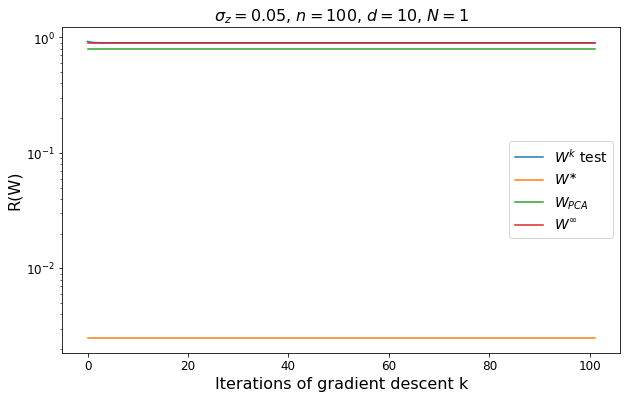



*****training size (N) = 2*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.73406326
Converged gradient descent: test risk: 0.80136828
15.362778786140536
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 145 due to early stopping
Gradient descent: test risk last: 0.80136824; test risk early stopped: 0.80136824; train loss: 2.962799276751138e-15


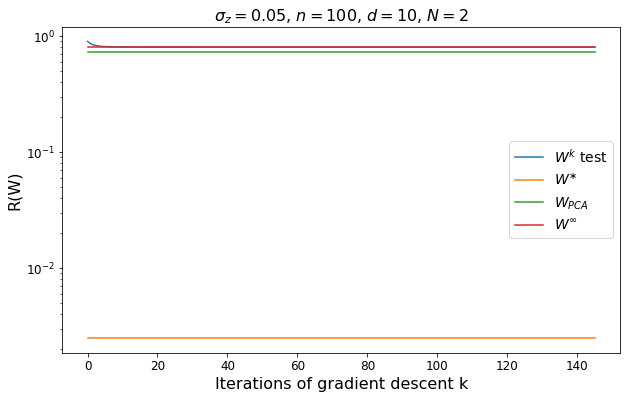



*****training size (N) = 4*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.60046405
Converged gradient descent: test risk: 0.60418439
10.86312505754881
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Stopped at iteration 331 due to early stopping
Gradient descent: test risk last: 0.60418445; test risk early stopped: 0.60418445; train loss: 3.5891747202348306e-14


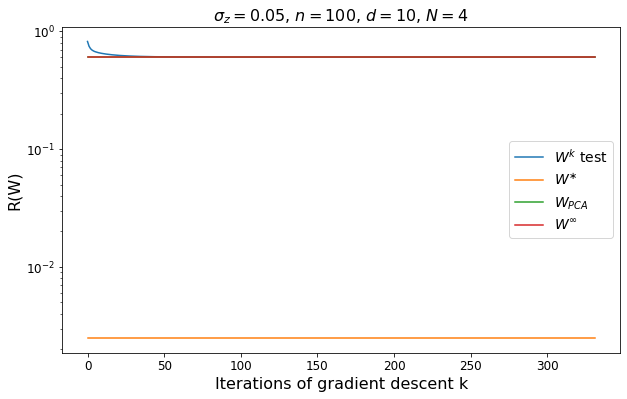



*****training size (N) = 8*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.29350524
Converged gradient descent: test risk: 0.25155556
7.681389393070268
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Iteration : 1500/5000
Iteration : 1600/5000
Iteration : 1700/5000
Iteration : 1800/5000
Iteration : 1900/5000
Stopped at iteration 1958 due to early stopping
Gradient descent: test risk last: 0.25155911; test risk early stopped: 0.25155911; train loss: 1.540311801717653e-11


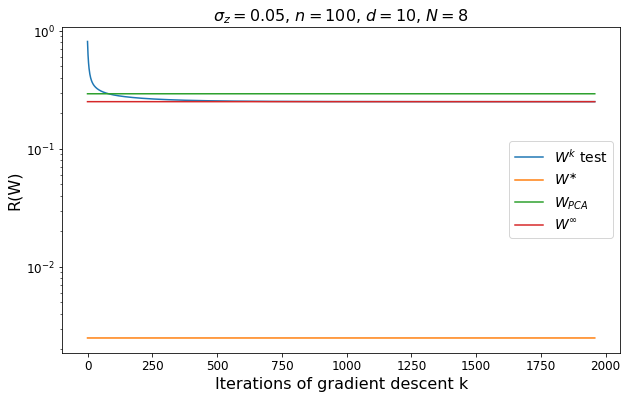



*****training size (N) = 10*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.17816989
Converged gradient descent: test risk: 0.12504601
6.870443537820389
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Iteration : 1500/5000
Iteration : 1600/5000
Iteration : 1700/5000
Iteration : 1800/5000
Iteration : 1900/5000
Iteration : 2000/5000
Stopped at iteration 2043 due to early stopping
Gradient descent: test risk last: 0.12504993; test risk early stopped: 0.12504993; train loss: 4.500530170759021e-09


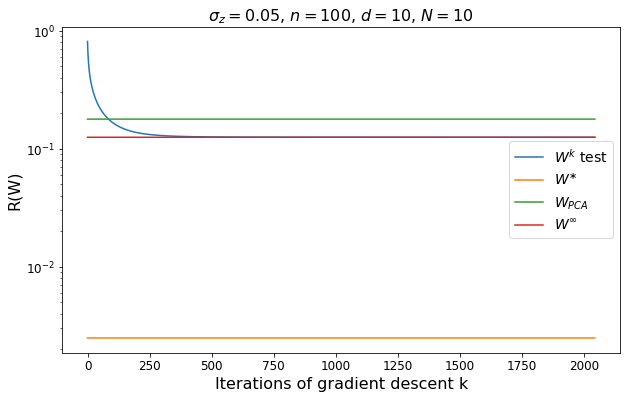



*****training size (N) = 12*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.08634896
Converged gradient descent: test risk: 0.03503405
6.271828176216375
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Iteration : 1500/5000
Iteration : 1600/5000
Iteration : 1700/5000
Iteration : 1800/5000
Iteration : 1900/5000
Iteration : 2000/5000
Iteration : 2100/5000
Stopped at iteration 2178 due to early stopping
Gradient descent: test risk last: 0.03503481; test risk early stopped: 0.03503481; train loss: 8.56333670640197e-09


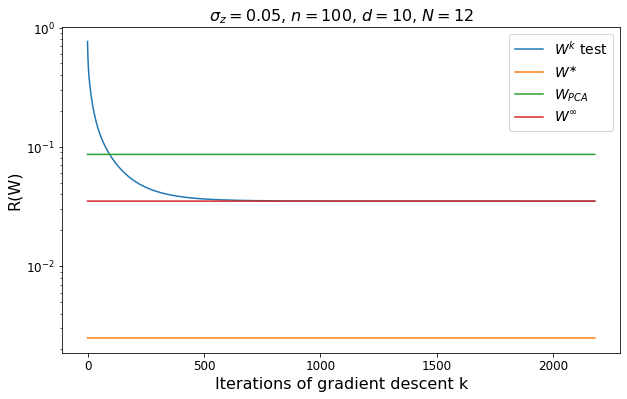



*****training size (N) = 14*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.05377673
Converged gradient descent: test risk: 0.01860264
5.806584587860943
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Stopped at iteration 694 due to early stopping
Gradient descent: test risk last: 0.01836611; test risk early stopped: 0.01835049; train loss: 3.694593397085555e-05


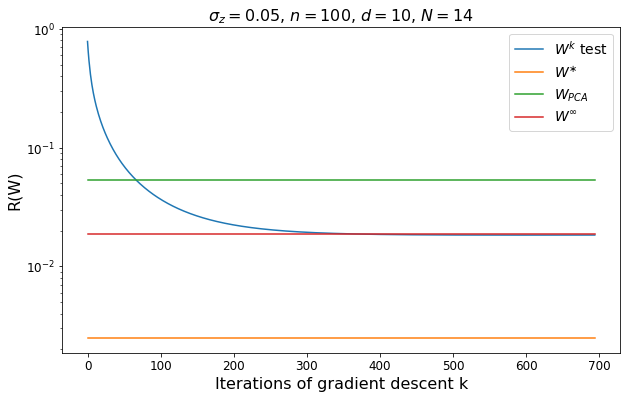



*****training size (N) = 16*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.04865481
Converged gradient descent: test risk: 0.01437558
5.431562528774405
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Stopped at iteration 611 due to early stopping
Gradient descent: test risk last: 0.01421477; test risk early stopped: 0.0142072; train loss: 0.00010995087359333411


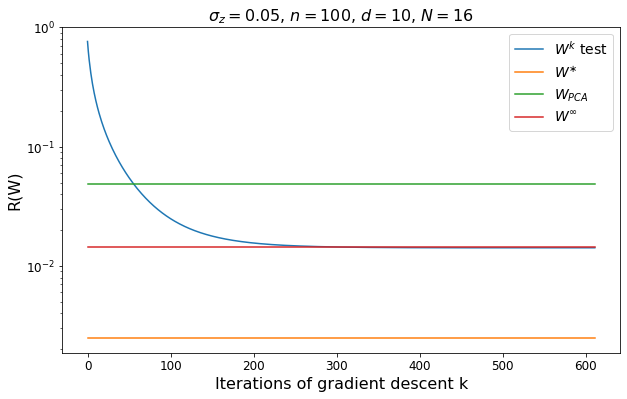



*****training size (N) = 18*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.02368349
Converged gradient descent: test risk: 0.00689835
5.120926262046845
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Stopped at iteration 469 due to early stopping
Gradient descent: test risk last: 0.00675104; test risk early stopped: 0.00674686; train loss: 0.00011812477896455675


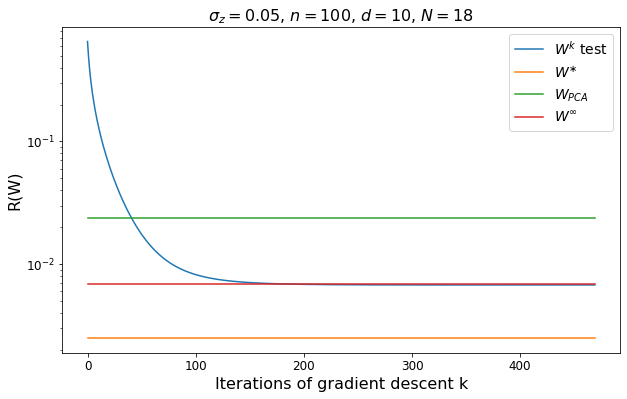



*****training size (N) = 22*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.02108437
Converged gradient descent: test risk: 0.0060645
4.632052088259977
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Stopped at iteration 295 due to early stopping
Gradient descent: test risk last: 0.00552235; test risk early stopped: 0.00549298; train loss: 0.0004633409553207457


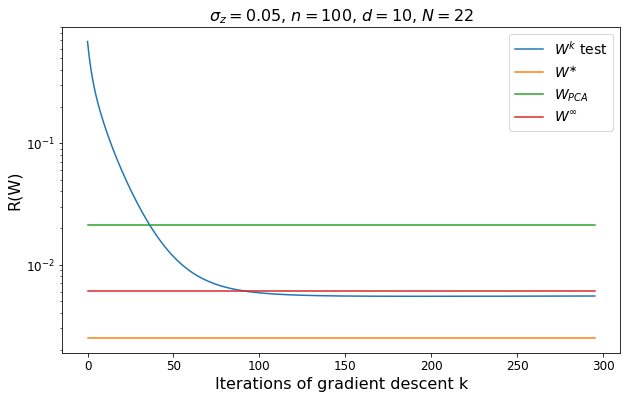



*****training size (N) = 24*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.02044583
Converged gradient descent: test risk: 0.0069591
4.434852233839456
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Stopped at iteration 330 due to early stopping
Gradient descent: test risk last: 0.005871; test risk early stopped: 0.00583096; train loss: 0.000600963132455945


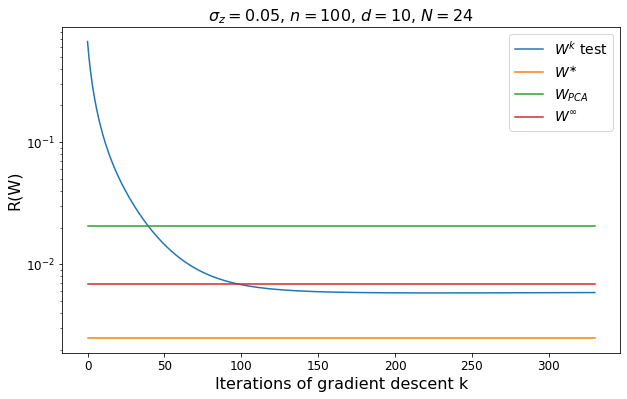



*****training size (N) = 30*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.01153009
Converged gradient descent: test risk: 0.00452758
3.9666524260127263
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Stopped at iteration 219 due to early stopping
Gradient descent: test risk last: 0.00363564; test risk early stopped: 0.00361065; train loss: 0.0009452577796764672


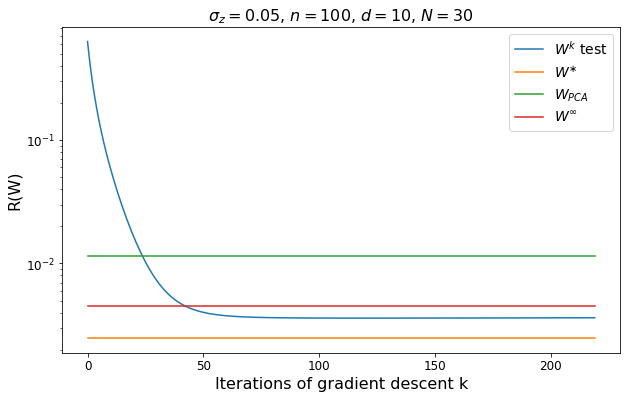



*****training size (N) = 36*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.01148678
Converged gradient descent: test risk: 0.00471814
3.6210416858496033
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Stopped at iteration 212 due to early stopping
Gradient descent: test risk last: 0.0033526; test risk early stopped: 0.00333533; train loss: 0.001199841732159257


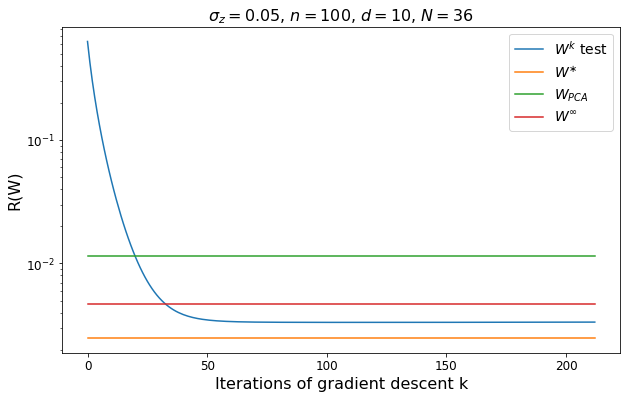



*****training size (N) = 44*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.0074892
Converged gradient descent: test risk: 0.00503876
3.2753554424179376
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 171 due to early stopping
Gradient descent: test risk last: 0.00318203; test risk early stopped: 0.00315394; train loss: 0.001381871523335576


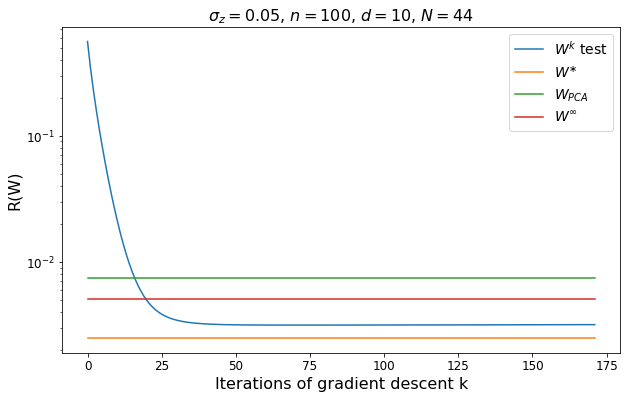



*****training size (N) = 64*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00640658
Converged gradient descent: test risk: 0.00607476
2.7157812643872026
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 163 due to early stopping
Gradient descent: test risk last: 0.00309144; test risk early stopped: 0.00307362; train loss: 0.001402157242409885


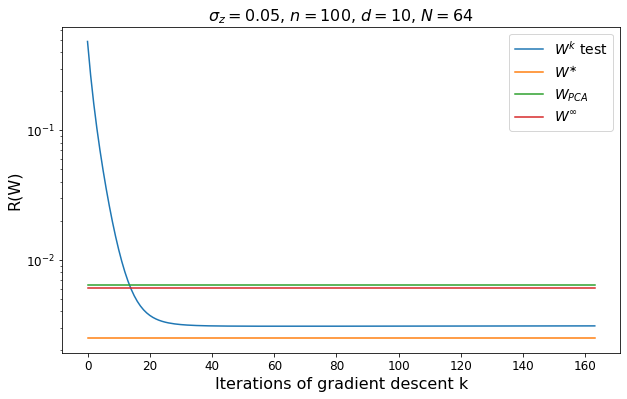



*****training size (N) = 100*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00493552
Converged gradient descent: test risk: 4.23803572
2.172625011509762
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 148 due to early stopping
Gradient descent: test risk last: 0.00283823; test risk early stopped: 0.00282525; train loss: 0.001873351284302771


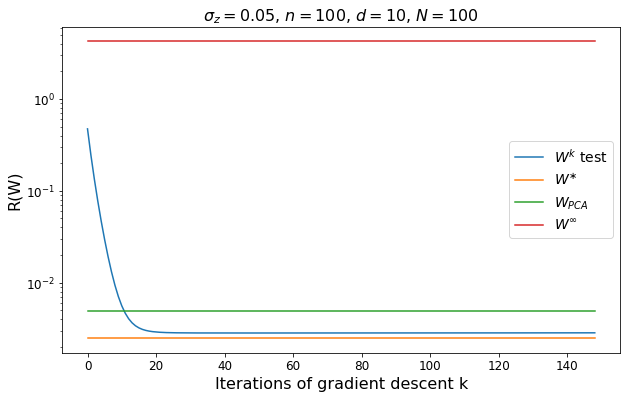



*****training size (N) = 256*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00342292
Converged gradient descent: test risk: 0.00397762
1.3578906321936013
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 122 due to early stopping
Gradient descent: test risk last: 0.00259424; test risk early stopped: 0.00258368; train loss: 0.0021245647221803665


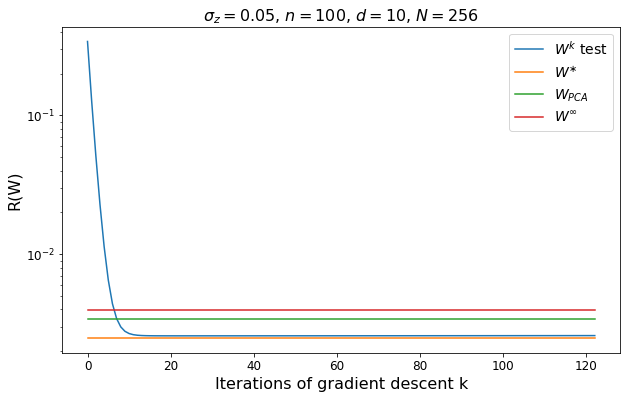



*****training size (N) = 512*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00297171
Converged gradient descent: test risk: 0.00318793
0.9601736741337835
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 114 due to early stopping
Gradient descent: test risk last: 0.00254917; test risk early stopped: 0.00254105; train loss: 0.002365246880799532


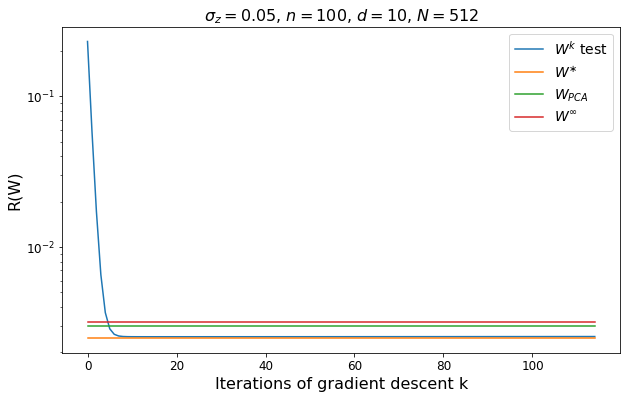



*****training size (N) = 1024*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00272239
Converged gradient descent: test risk: 0.00275869
0.6789453160968006
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 114 due to early stopping
Gradient descent: test risk last: 0.0025205; test risk early stopped: 0.00251519; train loss: 0.0024542997125536203


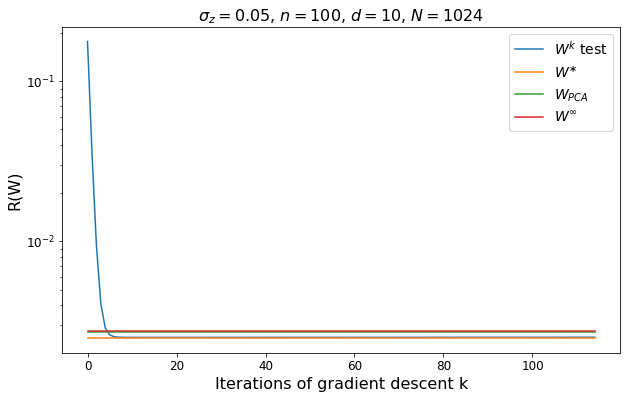



*****training size (N) = 2048*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.0025987
Converged gradient descent: test risk: 0.00261817
0.48008683706689176
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 109 due to early stopping
Gradient descent: test risk last: 0.00250639; test risk early stopped: 0.00250341; train loss: 0.0023755652364343405


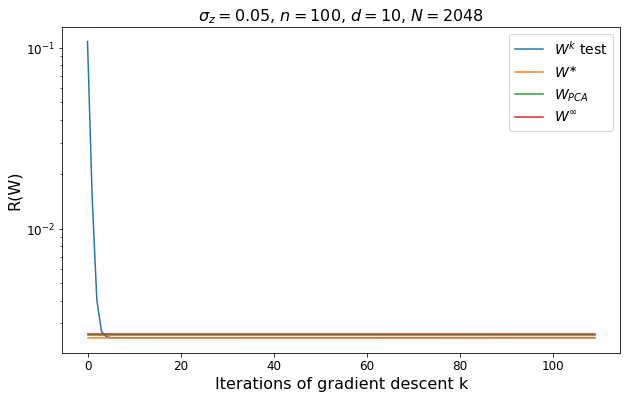



*****training size (N) = 4096*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00255328
Converged gradient descent: test risk: 0.00255961
0.3394726580484003
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 109 due to early stopping
Gradient descent: test risk last: 0.00250216; test risk early stopped: 0.0025002; train loss: 0.002458970993757248


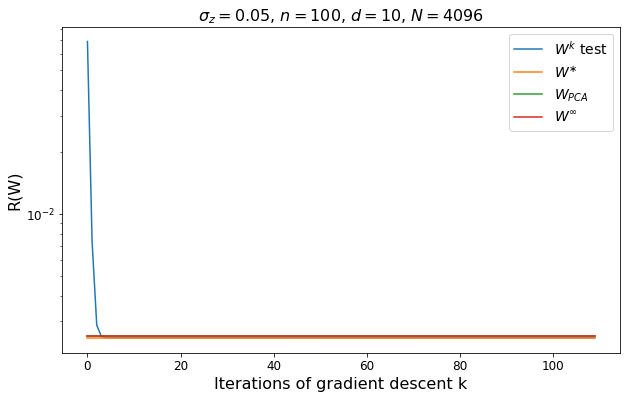



*****training size (N) = 8192*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00252079
Converged gradient descent: test risk: 0.00252528
0.24004341853344588
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 105 due to early stopping
Gradient descent: test risk last: 0.0024979; test risk early stopped: 0.00249688; train loss: 0.0024731773883104324


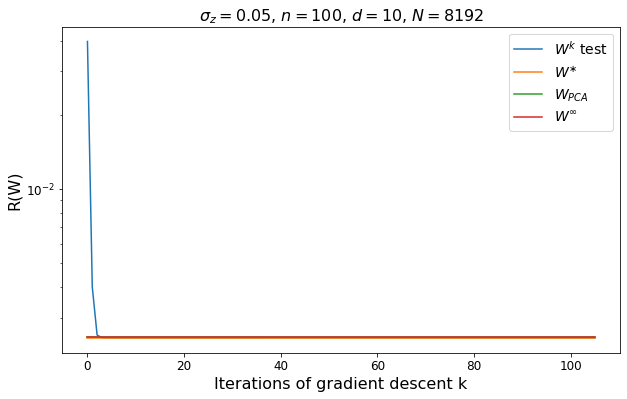



*****training size (N) = 16384*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00250841
Converged gradient descent: test risk: 0.00251053
0.16973632902420016
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 104 due to early stopping
Gradient descent: test risk last: 0.00249603; test risk early stopped: 0.00249543; train loss: 0.002505565993487835


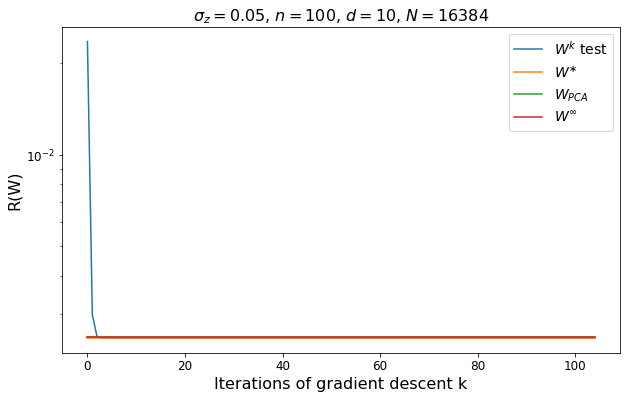



**********run 1**********
*****training size (N) = 1*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.82524019
Converged gradient descent: test risk: 0.90046526
21.72625011509762
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 101 due to convergence
Gradient descent: test risk last: 0.90046531; test risk early stopped: 0.90046531; train loss: 0.0


*****training size (N) = 2*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.7264449
Converged gradient descent: test risk: 0.80101234
15.362778786140536
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 119 due to convergence
Gradient descent: test risk last: 0.80101234; test risk early stopped: 0.80101234; train loss: 6.086087897721798e-16


*****training size (N) = 4*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.5937092
Converged gradient descent: test risk: 0.6057579
10.86312505754881
Iteration : 0/5000
Iteration : 100/5000
Iterat

Iteration : 100/5000
Stopped at iteration 136 due to early stopping
Gradient descent: test risk last: 0.00282746; test risk early stopped: 0.00280388; train loss: 0.0018327170982956886


*****training size (N) = 256*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00337343
Converged gradient descent: test risk: 0.00408258
1.3578906321936013
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 122 due to early stopping
Gradient descent: test risk last: 0.00260025; test risk early stopped: 0.00258919; train loss: 0.002142146462574601


*****training size (N) = 512*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00291302
Converged gradient descent: test risk: 0.00310608
0.9601736741337835
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 118 due to early stopping
Gradient descent: test risk last: 0.00255278; test risk early stopped: 0.00254416; train loss: 0.0023275278508663177


*****training size (N) = 1024*****
O

Iteration : 100/5000
Iteration : 200/5000
Stopped at iteration 277 due to early stopping
Gradient descent: test risk last: 0.00439218; test risk early stopped: 0.00434497; train loss: 0.0005835749907419086


*****training size (N) = 30*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.01450643
Converged gradient descent: test risk: 0.00479063
3.9666524260127263
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Stopped at iteration 232 due to early stopping
Gradient descent: test risk last: 0.00396451; test risk early stopped: 0.00394901; train loss: 0.0008453420014120638


*****training size (N) = 36*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.01042821
Converged gradient descent: test risk: 0.00561299
3.6210416858496033
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 173 due to early stopping
Gradient descent: test risk last: 0.00374699; test risk early stopped: 0.00369796; train loss: 0.00133191677741706

Stopped at iteration 2772 due to early stopping
Gradient descent: test risk last: 0.02519603; test risk early stopped: 0.02519603; train loss: 1.2966526463653594e-10


*****training size (N) = 14*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.07356577
Converged gradient descent: test risk: 0.02801091
5.806584587860943
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/5000
Iteration : 1000/5000
Iteration : 1100/5000
Iteration : 1200/5000
Iteration : 1300/5000
Iteration : 1400/5000
Iteration : 1500/5000
Iteration : 1600/5000
Iteration : 1700/5000
Iteration : 1800/5000
Iteration : 1900/5000
Iteration : 2000/5000
Iteration : 2100/5000
Iteration : 2200/5000
Iteration : 2300/5000
Iteration : 2400/5000
Iteration : 2500/5000
Iteration : 2600/5000
Iteration : 2700/5000
Iteration : 2800/5000
Iteration : 2900/5000
Ite

Iteration : 100/5000
Stopped at iteration 136 due to early stopping
Gradient descent: test risk last: 0.80079287; test risk early stopped: 0.80079287; train loss: 3.0984249217160757e-15


*****training size (N) = 4*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.59051656
Converged gradient descent: test risk: 0.60416276
10.86312505754881
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Stopped at iteration 339 due to early stopping
Gradient descent: test risk last: 0.60416287; test risk early stopped: 0.60416287; train loss: 3.6692969219683305e-14


*****training size (N) = 8*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.25771311
Converged gradient descent: test risk: 0.22622603
7.681389393070268
Iteration : 0/5000
Iteration : 100/5000
Iteration : 200/5000
Iteration : 300/5000
Iteration : 400/5000
Iteration : 500/5000
Iteration : 600/5000
Iteration : 700/5000
Iteration : 800/5000
Iteration : 900/

Converged gradient descent: test risk: 0.00262781
0.48008683706689176
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 107 due to early stopping
Gradient descent: test risk last: 0.00251071; test risk early stopped: 0.00250736; train loss: 0.0024587332736700773


*****training size (N) = 4096*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00255279
Converged gradient descent: test risk: 0.00255655
0.3394726580484003
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 107 due to early stopping
Gradient descent: test risk last: 0.00250104; test risk early stopped: 0.00249925; train loss: 0.002436995506286621


*****training size (N) = 8192*****
Optimal estimatior: test risk: 0.00249377
PCA estimation: test risk: 0.00252168
Converged gradient descent: test risk: 0.00252455
0.24004341853344588
Iteration : 0/5000
Iteration : 100/5000
Stopped at iteration 107 due to early stopping
Gradient descent: test risk last: 0.00249784; test risk early s

In [8]:
# Store results
PCA_est_results = {'test_l':np.zeros([runs,len(train_size)])}
GDconv_results = {'test_l':np.zeros([runs,len(train_size)])}
learn_results = {'test_l':{}, 'train_l_emp':{}}
opt_est_results = {'test_l':np.zeros([runs,len(train_size)])}



for r in range(runs):
    print("**********run {}**********".format(r))
    for i,N in enumerate(train_size):
        print("*****training size (N) = {}*****".format(N))
        data = dataGen(n, d)
        data.create_train_data(n, d, N, sigma_z=sigma_z)
        
        ### optimal estimation
        opt_est = optimal_estimator()
        teL = opt_est.compute_optimal_estimator(U = data.U.numpy(), sigma_z = sigma_z)
        opt_est_results['test_l'][r,i] = teL
        print("Optimal estimatior: test risk: {}".format(np.round(teL,precision)))


        ### PCA estimator
        PCA_est = PCA_based_reconstruction()
        teL = PCA_est.compute_subspace_estimate(trY = data.trY.numpy(), U = data.U.numpy(), sigma_z = sigma_z)
        PCA_est_results['test_l'][r,i] = teL
        print("PCA estimation: test risk: {}".format(np.round(teL,precision)))

        
        ### Estimator learned with gradient descent in the limit of infinite many iterations
        GDconv_est = gradient_descent_converged()
        teL = GDconv_est.compute_GDconv_estimate(data.trX.numpy(), data.trY.numpy(), data.U.numpy(), sigma_z)
        GDconv_results['test_l'][r,i] = teL
        print("Converged gradient descent: test risk: {}".format(np.round(teL,precision)))
        

        ### Estimator learned with gradient descent
        num_iters = 5000
        epsilon = np.sqrt(10* (d+sigma_z**2*n) * np.log(n) / N)
        print(epsilon)
        lr = 1/(N * (1+epsilon) * (1+sigma_z**2))
              
        learn_rec = GD_model(n)
        testL, trainL_emp = learn_rec.train(data.trX.type(dtype), data.trY.type(dtype), data.U.type(dtype), 
                                            sigma_z, num_iters, lr)
        learn_results['test_l'][str(r)+str(i)] = testL
        learn_results['train_l_emp'][str(r)+str(i)] = trainL_emp
        risk_last = np.round(learn_results['test_l'][str(r)+str(i)][-1],precision)
        risk_early_stopped = np.round(np.min(learn_results['test_l'][str(r)+str(i)]),precision)
        train_loss = learn_results['train_l_emp'][str(r)+str(i)][-1]
        print("Gradient descent: test risk last: {}; test risk early stopped: {}; train loss: {}".format(risk_last,risk_early_stopped,train_loss))           



        if r==0:
            fontsize = 16
            fig = plt.figure(figsize=(10,6))
            alpha=0.8
            ax = fig.add_subplot(111)
            steps = len(learn_results['test_l'][str(r)+str(i)])
            #ax.plot(range(steps), learn_results['train_l_emp'][str(r)+str(i)],label=r"$W^{k}$ train")
            ax.plot(range(steps), learn_results['test_l'][str(r)+str(i)], label=r"$W^{k}$ test")
            ax.plot(range(steps), [opt_est_results['test_l'][r,i]]*steps,label=r"$W^{\ast}$")
            ax.plot(range(steps), [PCA_est_results['test_l'][r,i]]*steps,label=r"$W_{PCA}$")
            ax.plot(range(steps), [GDconv_results['test_l'][r,i]]*steps,label=r"$W^{\infty}$")
            ax.set_yscale('log')
            ax.set_title('$\sigma_z=${}, $n=${}, $d=${}, $N=${}'.format(sigma_z,n,d,N), fontsize=fontsize)
            ax.tick_params(axis='x', labelsize=fontsize-4 ) 
            ax.tick_params(axis='y', labelsize=fontsize-4 ) 
            ax.set_xlabel('Iterations of gradient descent k', fontsize=fontsize)
            ax.set_ylabel('R(W)', fontsize=fontsize)
            ax.legend(fontsize=fontsize-2)
            plt.show()

        print("\n")

In [9]:
#######
# Compute mean and std for plot
#######
# test performance of early stopped gradient descent
learn_results_ES = {'test_l':np.zeros([runs,len(train_size)])}
for r in range(runs):
    for i in range(len(train_size)):
        learn_results_ES['test_l'][r,i] = np.min(learn_results['test_l'][str(r)+str(i)])

PCA_est_M = PCA_est_results['test_l'].mean(0)
PCA_est_S = PCA_est_results['test_l'].std(0)
GDconv_est_M = GDconv_results['test_l'].mean(0)
GDconv_est_S = GDconv_results['test_l'].std(0)
learn_results_ES_M = learn_results_ES['test_l'].mean(0)
learn_results_ES_S = learn_results_ES['test_l'].std(0)
opt_est_M = opt_est_results['test_l'].mean(0)
opt_est_S = opt_est_results['test_l'].std(0)

## Fit linear power laws to the power law regions of $W^{k_{opt}}$ and $W_{PCA}$ 

In [10]:
# Look up table that defines the start and end point of the power law regions for the estimators given a setup
look_up_power_law_regions = {
    'sigz01_d10_n100' : {
        'start_x' : [8,10],
        'end_x' : [24,44]
    },
    'sigz02_d10_n100' : {
        'start_x' : [8,10],
        'end_x' : [24,44]
    },
    'sigz005_d10_n100' : {
        'start_x' : [8,10],
        'end_x' : [24,44]
    },
    'sigz01_d10_n1000' : {
        'start_x' : [18, 80],
        'end_x' : [80, 256]
    },
    'sigz01_d10_n10000' : {
        'start_x' : [100, 512],
        'end_x' : [256, 2048]
    },
    'sigz01_d50_n1000' : {
        'start_x' : [50, 50],
        'end_x' : [100, 256]
    },
    'sigz01_d100_n1000' : {
        'start_x' : [80, 80],
        'end_x' : [175, 175]
    },
    'sigz005_d10_n1000' : {
        'start_x' : [10, 10],
        'end_x' : [44, 100]
    }
}

In [11]:
start_GD = look_up_power_law_regions[key]['start_x'][0]
end_GD = look_up_power_law_regions[key]['end_x'][0]

start_PCA = look_up_power_law_regions[key]['start_x'][1]
end_PCA = look_up_power_law_regions[key]['end_x'][1]

#####
# Linear fit of learned estimator
#####
# train_size at which power-law regime begins
start_ind = np.where(np.array(train_size)==start_GD)[0][0]
# train_size at which power-law regime ends
end_ind = np.where(np.array(train_size)==end_GD)[0][0]

# find linear fit 
y = np.log10(learn_results_ES_M[start_ind:end_ind+1])
x = np.vstack((np.log10(np.array(train_size)[start_ind:end_ind+1]),np.ones(y.shape))).T

linfit_w = np.linalg.inv(x.T@x) @ x.T@y

# power-law: R = beta * N**alpha
beta = 10**linfit_w[1]
alpha = linfit_w[0]
print(beta,alpha)
linfit = beta * np.array(train_size)**alpha

#####
# Linear fit of noisy subspace estimator
#####
# train_size at which power-law regime begins
start_ind = np.where(np.array(train_size)==start_PCA)[0][0]
# train_size at which power-law regime ends
end_ind = np.where(np.array(train_size)==end_PCA)[0][0]

# find linear fit 
y = np.log10(PCA_est_M[start_ind:end_ind+1])
x = np.vstack((np.log10(np.array(train_size)[start_ind:end_ind+1]),np.ones(y.shape))).T

linfit_w = np.linalg.inv(x.T@x) @ x.T@y

# power-law: R = beta * N**alpha
beta_2 = 10**linfit_w[1]
alpha_2 = linfit_w[0]
print(beta_2,alpha_2)
linfit_2 = beta_2 * np.array(train_size)**alpha_2

390.29399688206 -3.657632648196683
10.435659758809015 -1.9313628103834832


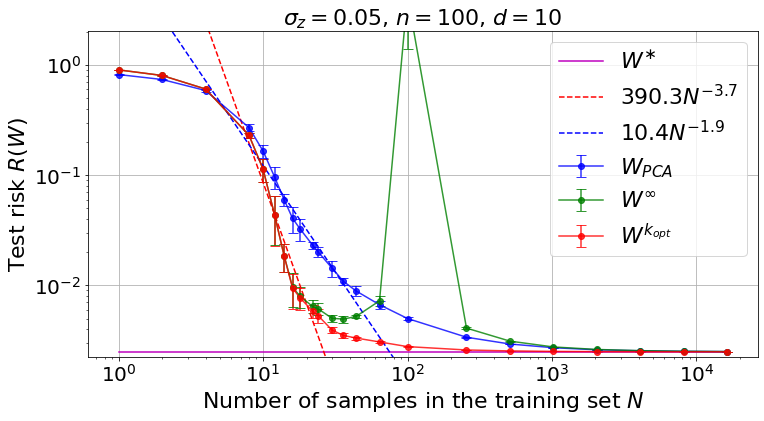

In [13]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)
ax.errorbar(train_size, PCA_est_M, yerr=PCA_est_S, color='b', fmt="-o",alpha=al,label=r"$W_{PCA}$", capsize=5)
ax.errorbar(train_size, GDconv_est_M, yerr=GDconv_est_S, color='g', fmt="-o",alpha=al,label=r"$W^{\infty}$", capsize=5)
ax.errorbar(train_size, learn_results_ES_M, yerr=learn_results_ES_S, color='r', fmt="-o",alpha=al,label=r"$W^{k_{opt}}$", capsize=5)
ax.plot(train_size, opt_est_M,color='m', label=r"$W^{\ast}$")


ax.plot(train_size[:linfit.shape[0]], linfit,linestyle='--', color='r',label=r"${%.1f} N^{%.1f}$"%(np.round(beta,1),np.round(alpha,1)))
ax.plot(train_size[:linfit_2.shape[0]], linfit_2,linestyle='--',color='b',label=r"${%.1f} N^{%.1f}$"%(np.round(beta_2,1),np.round(alpha_2,1)))

ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_z=${}, $n=${}, $d=${}'.format(sigma_z,n,d), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([opt_est_M[0]*0.9,2.04])

plt.grid()
plt.show()